# Assignment 1:  Neural Machine Translation

Welcome to the first assignment of Course 4. Here, you will build an English-to-German neural machine translation (NMT) model using Long Short-Term Memory (LSTM) networks with attention.  Machine translation is an important task in natural language processing and could be useful not only for translating one language to another but also for word sense disambiguation (e.g. determining whether the word "bank" refers to the financial bank, or the land alongside a river). Implementing this using just a Recurrent Neural Network (RNN) with LSTMs can work for short to medium length sentences but can result in vanishing gradients for very long sequences. To solve this, you will be adding an attention mechanism to allow the decoder to access all relevant parts of the input sentence regardless of its length. By completing this assignment, you will:  

- learn how to preprocess your training and evaluation data
- implement an encoder-decoder system with attention
- understand how attention works
- build the NMT model from scratch using Trax
- generate translations using greedy and Minimum Bayes Risk (MBR) decoding 
## Outline
- [Part 1:  Data Preparation](#1)
    - [1.1  Importing the Data](#1.1)
    - [1.2  Tokenization and Formatting](#1.2)
    - [1.3  Tokenize & detokenize helper functions](#1.3)
    - [1.4  Bucketing](#1.4)
    - [1.5  Exploring the data](#1.5)
- [Part 2:  Neural Machine Translation with Attention](#2)
    - [2.1  Attention Overview](#2.1)
    - [2.2  Helper functions](#2.2)
        - [Exercise 01](#ex01)
        - [Exercise 02](#ex02)
        - [Exercise 03](#ex03)
    - [2.3  Implementation Overview](#2.3)
        - [Exercise 04](#ex04)
- [Part 3:  Training](#3)
    - [3.1  TrainTask](#3.1)
        - [Exercise 05](#ex05)
    - [3.2  EvalTask](#3.2)
    - [3.3  Loop](#3.3)
- [Part 4:  Testing](#4)
    - [4.1  Decoding](#4.1)
        - [Exercise 06](#ex06)
        - [Exercise 07](#ex07)
    - [4.2  Minimum Bayes-Risk Decoding](#4.2)
        - [Exercise 08](#ex08)
        - [Exercise 09](#ex09)
        - [Exercise 10](#ex10)


<a name="1"></a>
# Part 1:  Data Preparation


<a name="1.1"></a>
## 1.1  Importing the Data

We will first start by importing the packages we will use in this assignment. As in the previous course of this specialization, we will use the [Trax](https://github.com/google/trax) library created and maintained by the [Google Brain team](https://research.google/teams/brain/) to do most of the heavy lifting. It provides submodules to fetch and process the datasets, as well as build and train the model.

In [ ]:
from termcolor import colored
import random
import numpy as np

import trax
from trax import layers as tl
from trax.fastmath import numpy as fastnp
from trax.supervised import training

import w1_unittest

!pip list | grep trax

trax                         1.3.9
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


Next, we will import the dataset we will use to train the model. To meet the storage constraints in this lab environment, we will just use a small dataset from [Opus](http://opus.nlpl.eu/), a growing collection of translated texts from the web. Particularly, we will get an English to German translation subset specified as `opus/medical` which has medical related texts. If storage is not an issue, you can opt to get a larger corpus such as the English to German translation dataset from [ParaCrawl](https://paracrawl.eu/), a large multi-lingual translation dataset created by the European Union. Both of these datasets are available via [Tensorflow Datasets (TFDS)](https://www.tensorflow.org/datasets)
and you can browse through the other available datasets [here](https://www.tensorflow.org/datasets/catalog/overview). We have downloaded the data for you in the `data/` directory of your workspace. As you'll see below, you can easily access this dataset from TFDS with `trax.data.TFDS`. The result is a python generator function yielding tuples. Use the `keys` argument to select what appears at which position in the tuple. For example, `keys=('en', 'de')` below will return pairs as (English sentence, German sentence).  

In [ ]:
# Get generator function for the training set
# This will download the train dataset if no data_dir is specified.
train_stream_fn = trax.data.TFDS('opus/medical',
                                 data_dir='./data/',
                                 keys=('en', 'de'),
                                 eval_holdout_size=0.01, # 1% for eval
                                 train=True
                                )

# Get generator function for the eval set
eval_stream_fn = trax.data.TFDS('opus/medical',
                                data_dir='./data/',
                                keys=('en', 'de'),
                                eval_holdout_size=0.01, # 1% for eval                                
                                train=False
                               )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Notice that TFDS returns a generator *function*, not a generator. This is because in Python, you cannot reset generators so you cannot go back to a previously yielded value. During deep learning training, you use Stochastic Gradient Descent and don't actually need to go back -- but it is sometimes good to be able to do that, and that's where the functions come in. It is actually very common to use generator functions in Python -- e.g., `zip` is a generator function. You can read more about [Python generators](https://book.pythontips.com/en/latest/generators.html) to understand why we use them. Let's print a a sample pair from our train and eval data. Notice that the raw ouput is represented in bytes (denoted by the `b'` prefix) and these will be converted to strings internally in the next steps.

In [ ]:
train_stream = train_stream_fn()
print(colored('train data (en, de) tuple:', 'red'), next(train_stream))
print()

eval_stream = eval_stream_fn()
print(colored('eval data (en, de) tuple:', 'red'), next(eval_stream))

train data (en, de) tuple: (b'In the pregnant rat the AUC for calculated free drug at this dose was approximately 18 times the human AUC at a 20 mg dose.\n', b'Bei tr\xc3\xa4chtigen Ratten war die AUC f\xc3\xbcr die berechnete ungebundene Substanz bei dieser Dosis etwa 18-mal h\xc3\xb6her als die AUC beim Menschen bei einer 20 mg Dosis.\n')

eval data (en, de) tuple: (b'Subcutaneous use and intravenous use.\n', b'Subkutane Anwendung und intraven\xc3\xb6se Anwendung.\n')


<a name="1.2"></a>
## 1.2  Tokenization and Formatting

Now that we have imported our corpus, we will be preprocessing the sentences into a format that our model can accept. This will be composed of several steps:

**Tokenizing the sentences using subword representations:** As you've learned in the earlier courses of this specialization, we want to represent each sentence as an array of integers instead of strings. For our application, we will use *subword* representations to tokenize our sentences. This is a common technique to avoid out-of-vocabulary words by allowing parts of words to be represented separately. For example, instead of having separate entries in your vocabulary for --"fear", "fearless", "fearsome", "some", and "less"--, you can simply store --"fear", "some", and "less"-- then allow your tokenizer to combine these subwords when needed. This allows it to be more flexible so you won't have to save uncommon words explicitly in your vocabulary (e.g. *stylebender*, *nonce*, etc). Tokenizing is done with the `trax.data.Tokenize()` command and we have provided you the combined subword vocabulary for English and German (i.e. `ende_32k.subword`) saved in the `data` directory. Feel free to open this file to see how the subwords look like.

In [ ]:
# global variables that state the filename and directory of the vocabulary file
VOCAB_FILE = 'ende_32k.subword'
VOCAB_DIR = 'data/'

# Tokenize the dataset.
tokenized_train_stream = trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)(train_stream)
tokenized_eval_stream = trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)(eval_stream)

**Append an end-of-sentence token to each sentence:** We will assign a token (i.e. in this case `1`) to mark the end of a sentence. This will be useful in inference/prediction so we'll know that the model has completed the translation.

In [ ]:
# Append EOS at the end of each sentence.

# Integer assigned as end-of-sentence (EOS)
EOS = 1

# generator helper function to append EOS to each sentence
def append_eos(stream):
    for (inputs, targets) in stream:
        inputs_with_eos = list(inputs) + [EOS]
        targets_with_eos = list(targets) + [EOS]
        yield np.array(inputs_with_eos), np.array(targets_with_eos)

# append EOS to the train data
tokenized_train_stream = append_eos(tokenized_train_stream)

# append EOS to the eval data
tokenized_eval_stream = append_eos(tokenized_eval_stream)

**Filter long sentences:** We will place a limit on the number of tokens per sentence to ensure we won't run out of memory. This is done with the `trax.data.FilterByLength()` method and you can see its syntax below.

In [ ]:
# Filter too long sentences to not run out of memory.
# length_keys=[0, 1] means we filter both English and German sentences, so
# both must be not longer that 256 tokens for training / 512 for eval.
filtered_train_stream = trax.data.FilterByLength(
    max_length=512, length_keys=[0, 1])(tokenized_train_stream)
filtered_eval_stream = trax.data.FilterByLength(
    max_length=512, length_keys=[0, 1])(tokenized_eval_stream)

# print a sample input-target pair of tokenized sentences
train_input, train_target = next(filtered_train_stream)
print(colored(f'Single tokenized example input:', 'red' ), train_input)
print(colored(f'Single tokenized example target:', 'red'), train_target)

Single tokenized example input: [ 8569  4094  2679 32826 22527     5 30650  4729   992     1]
Single tokenized example target: [12647 19749    70 32826 10008     5 30650  4729   992     1]


<a name="1.3"></a>
## 1.3  tokenize & detokenize helper functions

Given any data set, you have to be able to map words to their indices, and indices to their words. The inputs and outputs to your trax models are usually tensors of numbers where each number corresponds to a word. If you were to process your data manually, you would have to make use of the following: 

- <span style='color:blue'> word2Ind: </span> a dictionary mapping the word to its index.
- <span style='color:blue'> ind2Word:</span> a dictionary mapping the index to its word.
- <span style='color:blue'> word2Count:</span> a dictionary mapping the word to the number of times it appears. 
- <span style='color:blue'> num_words:</span> total number of words that have appeared. 

Since you have already implemented these in previous assignments of the specialization, we will provide you with helper functions that will do this for you. Run the cell below to get the following functions:

- <span style='color:blue'> tokenize(): </span> converts a text sentence to its corresponding token list (i.e. list of indices). Also converts words to subwords (parts of words).
- <span style='color:blue'> detokenize(): </span> converts a token list to its corresponding sentence (i.e. string).

In [ ]:
# Setup helper functions for tokenizing and detokenizing sentences

def tokenize(input_str, vocab_file=None, vocab_dir=None):
    """Encodes a string to an array of integers

    Args:
        input_str (str): human-readable string to encode
        vocab_file (str): filename of the vocabulary text file
        vocab_dir (str): path to the vocabulary file
  
    Returns:
        numpy.ndarray: tokenized version of the input string
    """
    
    # Set the encoding of the "end of sentence" as 1
    EOS = 1
    
    # Use the trax.data.tokenize method. It takes streams and returns streams,
    # we get around it by making a 1-element stream with `iter`.
    inputs =  next(trax.data.tokenize(iter([input_str]),
                                      vocab_file=vocab_file, vocab_dir=vocab_dir))
    
    # Mark the end of the sentence with EOS
    inputs = list(inputs) + [EOS]
    
    # Adding the batch dimension to the front of the shape
    batch_inputs = np.reshape(np.array(inputs), [1, -1])
    
    return batch_inputs


def detokenize(integers, vocab_file=None, vocab_dir=None):
    """Decodes an array of integers to a human readable string

    Args:
        integers (numpy.ndarray): array of integers to decode
        vocab_file (str): filename of the vocabulary text file
        vocab_dir (str): path to the vocabulary file
  
    Returns:
        str: the decoded sentence.
    """
    
    # Remove the dimensions of size 1
    integers = list(np.squeeze(integers))
    
    # Set the encoding of the "end of sentence" as 1
    EOS = 1
    
    # Remove the EOS to decode only the original tokens
    if EOS in integers:
        integers = integers[:integers.index(EOS)] 
    
    return trax.data.detokenize(integers, vocab_file=vocab_file, vocab_dir=vocab_dir)

Let's see how we might use these functions:

In [ ]:
# As declared earlier:
# VOCAB_FILE = 'ende_32k.subword'
# VOCAB_DIR = 'data/'

# Detokenize an input-target pair of tokenized sentences
print(colored(f'Single detokenized example input:', 'red'), detokenize(train_input, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f'Single detokenized example target:', 'red'), detokenize(train_target, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print()

# Tokenize and detokenize a word that is not explicitly saved in the vocabulary file.
# See how it combines the subwords -- 'hell' and 'o'-- to form the word 'hello'.
print(colored(f"tokenize('hello'): ", 'green'), tokenize('hello', vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f"detokenize([17332, 140, 1]): ", 'green'), detokenize([17332, 140, 1], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))

Single detokenized example input: Decreased Appetite

Single detokenized example target: Verminderter Appetit


tokenize('hello'):  [[17332   140     1]]
detokenize([17332, 140, 1]):  hello


<a name="1.4"></a>
## 1.4  Bucketing

Bucketing the tokenized sentences is an important technique used to speed up training in NLP.
Here is a 
[nice article describing it in detail](https://medium.com/@rashmi.margani/how-to-speed-up-the-training-of-the-sequence-model-using-bucketing-techniques-9e302b0fd976)
but the gist is very simple. Our inputs have variable lengths and you want to make these the same when batching groups of sentences together. One way to do that is to pad each sentence to the length of the longest sentence in the dataset. This might lead to some wasted computation though. For example, if there are multiple short sentences with just two tokens, do we want to pad these when the longest sentence is composed of a 100 tokens? Instead of padding with 0s to the maximum length of a sentence each time, we can group our tokenized sentences by length and bucket, as on this image (from the article above):

![alt text](https://miro.medium.com/max/700/1*hcGuja_d5Z_rFcgwe9dPow.png)

We batch the sentences with similar length together (e.g. the blue sentences in the image above) and only add minimal padding to make them have equal length (usually up to the nearest power of two). This allows to waste less computation when processing padded sequences.
In Trax, it is implemented in the [bucket_by_length](https://github.com/google/trax/blob/5fb8aa8c5cb86dabb2338938c745996d5d87d996/trax/supervised/inputs.py#L378) function.

In [ ]:
# Bucketing to create streams of batches.

# Buckets are defined in terms of boundaries and batch sizes.
# Batch_sizes[i] determines the batch size for items with length < boundaries[i]
# So below, we'll take a batch of 256 sentences of length < 8, 128 if length is
# between 8 and 16, and so on -- and only 2 if length is over 512.
boundaries =  [8,   16,  32, 64, 128, 256, 512]
batch_sizes = [256, 128, 64, 32, 16,    8,   4,  2]

# Create the generators.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes,
    length_keys=[0, 1]  # As before: count inputs and targets to length.
)(filtered_train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes,
    length_keys=[0, 1]  # As before: count inputs and targets to length.
)(filtered_eval_stream)

# Add masking for the padding (0s).
train_batch_stream = trax.data.AddLossWeights(id_to_mask=0)(train_batch_stream)
eval_batch_stream = trax.data.AddLossWeights(id_to_mask=0)(eval_batch_stream)

<a name="1.5"></a>
## 1.5  Exploring the data

We will now be displaying some of our data. You will see that the functions defined above (i.e. `tokenize()` and `detokenize()`) do the same things you have been doing again and again throughout the specialization. We gave these so you can focus more on building the model from scratch. Let us first get the data generator and get one batch of the data.

In [ ]:
input_batch, target_batch, mask_batch = next(train_batch_stream)

# let's see the data type of a batch
print("input_batch data type: ", type(input_batch))
print("target_batch data type: ", type(target_batch))

# let's see the shape of this particular batch (batch length, sentence length)
print("input_batch shape: ", input_batch.shape)
print("target_batch shape: ", target_batch.shape)

input_batch data type:  <class 'numpy.ndarray'>
target_batch data type:  <class 'numpy.ndarray'>
input_batch shape:  (32, 64)
target_batch shape:  (32, 64)


The `input_batch` and `target_batch` are Numpy arrays consisting of tokenized English sentences and German sentences respectively. These tokens will later be used to produce embedding vectors for each word in the sentence (so the embedding for a sentence will be a matrix). The number of sentences in each batch is usually a power of 2 for optimal computer memory usage. 

We can now visually inspect some of the data. You can run the cell below several times to shuffle through the sentences. Just to note, while this is a standard data set that is used widely, it does have some known wrong translations. With that, let's pick a random sentence and print its tokenized representation.

In [ ]:
# pick a random index less than the batch size.
index = random.randrange(len(input_batch))

# use the index to grab an entry from the input and target batch
print(colored('THIS IS THE ENGLISH SENTENCE: \n', 'red'), detokenize(input_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR), '\n')
print(colored('THIS IS THE TOKENIZED VERSION OF THE ENGLISH SENTENCE: \n ', 'red'), input_batch[index], '\n')
print(colored('THIS IS THE GERMAN TRANSLATION: \n', 'red'), detokenize(target_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR), '\n')
print(colored('THIS IS THE TOKENIZED VERSION OF THE GERMAN TRANSLATION: \n', 'red'), target_batch[index], '\n')

THIS IS THE ENGLISH SENTENCE: 
 Galantamine and donepezil do not show a clinically relevant effect on the pharmacokinetics of risperidone and on the active antipsychotic fraction.
 

THIS IS THE TOKENIZED VERSION OF THE ENGLISH SENTENCE: 
  [32114  6083 10166     8  5305  4472 24010   215   127    48  1026    13
 20571  1805  3031  1520    22     4  6826  7211  3853  8834 20293  1978
     7  6804  5499   866     8    22     4  2373  2646 10108  2390 29246
  3550 30650  4729   992     1     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0] 

THIS IS THE GERMAN TRANSLATION: 
 Galantamin und Donepezil zeigen keine klinisch relevanten Auswirkungen auf die Pharmakokinetik von Risperidon und der aktiven antipsychotischen Fraktion.
 

THIS IS THE TOKENIZED VERSION OF THE GERMAN TRANSLATION: 
 [32114  6083  5251    12 18623  4472 24010   215  1628   249 23489  1212
 12039    23  1191    37    10 15881 23486 

<a name="2"></a>
# Part 2:  Neural Machine Translation with Attention

Now that you have the data generators and have handled the preprocessing, it is time for you to build the model. You will be implementing a neural machine translation model from scratch with attention.


<a name="2.1"></a>
## 2.1  Attention Overview

The model we will be building uses an encoder-decoder architecture. This Recurrent Neural Network (RNN) will take in a tokenized version of a sentence in its encoder, then passes it on to the decoder for translation. As mentioned in the lectures, just using a a regular sequence-to-sequence model with LSTMs will work effectively for short to medium sentences but will start to degrade for longer ones. You can picture it like the figure below where all of the context of the input sentence is compressed into one vector that is passed into the decoder block. You can see how this will be an issue for very long sentences (e.g. 100 tokens or more) because the context of the first parts of the input will have very little effect on the final vector passed to the decoder.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>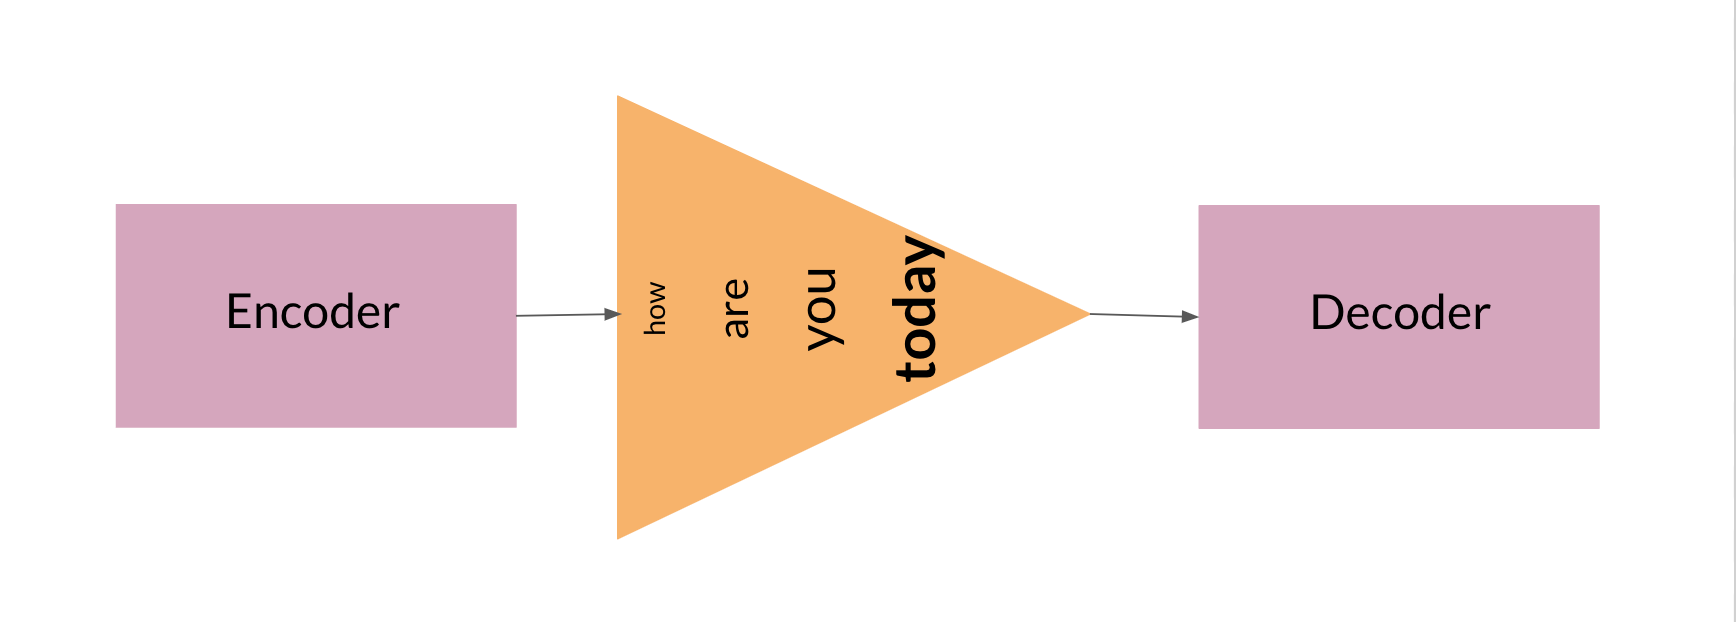</body></html>
<img src='images/plain_rnn.png'>

Adding an attention layer to this model avoids this problem by giving the decoder access to all parts of the input sentence. To illustrate, let's just use a 4-word input sentence as shown below. Remember that a hidden state is produced at each timestep of the encoder (represented by the orange rectangles). These are all passed to the attention layer and each are given a score given the current activation (i.e. hidden state) of the decoder. For instance, let's consider the figure below where the first prediction "Wie" is already made. To produce the next prediction, the attention layer will first receive all the encoder hidden states (i.e. orange rectangles) as well as the decoder hidden state when producing the word "Wie" (i.e. first green rectangle). Given this information, it will score each of the encoder hidden states to know which one the decoder should focus on to produce the next word. As a result of training, the model might have learned that it should align to the second encoder hidden state and subsequently assigns a high probability to the word "geht". If we are using greedy decoding, we will output the said word as the next symbol, then restart the process to produce the next word until we reach an end-of-sentence prediction.

<img src='images/attention_overview.png'>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>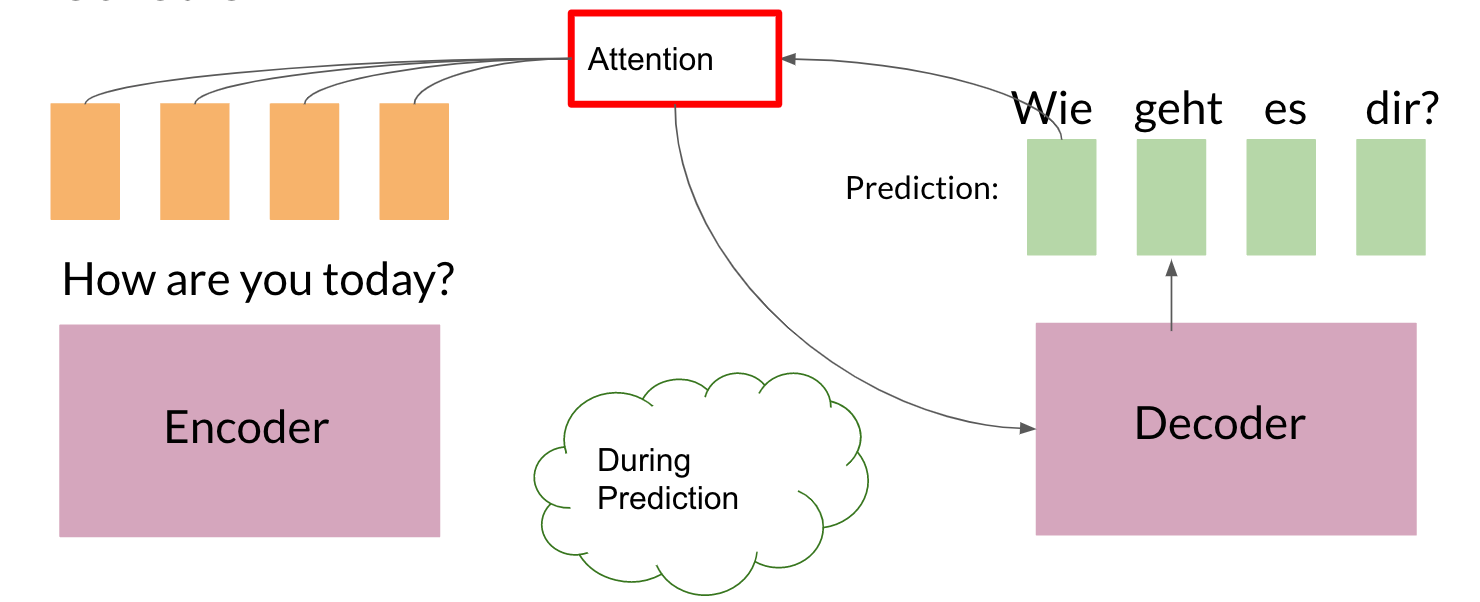</body></html>

There are different ways to implement attention and the one we'll use for this assignment is the Scaled Dot Product Attention which has the form:

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

You will dive deeper into this equation in the next week but for now, you can think of it as computing scores using queries (Q) and keys (K), followed by a multiplication of values (V) to get a context vector at a particular timestep of the decoder. This context vector is fed to the decoder RNN to get a set of probabilities for the next predicted word. The division by square root of the keys dimensionality ($\sqrt{d_k}$) is for improving model performance and you'll also learn more about it next week. For our machine translation application, the encoder activations (i.e. encoder hidden states) will be the keys and values, while the decoder activations (i.e. decoder hidden states) will be the queries.

You will see in the upcoming sections that this complex architecture and mechanism can be implemented with just a few lines of code. Let's get started!

<a name="2.2"></a>
## 2.2  Helper functions

We will first implement a few functions that we will use later on. These will be for the input encoder, pre-attention decoder, and preparation of the queries, keys, values, and mask.

### 2.2.1 Input encoder

The input encoder runs on the input tokens, creates its embeddings, and feeds it to an LSTM network. This outputs the activations that will be the keys and values for attention. It is a [Serial](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial) network which uses:

   - [tl.Embedding](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding): Converts each token to its vector representation. In this case, it is the the size of the vocabulary by the dimension of the model: `tl.Embedding(vocab_size, d_model)`. `vocab_size` is the number of entries in the given vocabulary. `d_model` is the number of elements in the word embedding.
  
   - [tl.LSTM](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.LSTM): LSTM layer of size `d_model`. We want to be able to configure how many encoder layers we have so remember to create LSTM layers equal to the number of the `n_encoder_layers` parameter.
   
<img src = "images/input_encoder.png">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>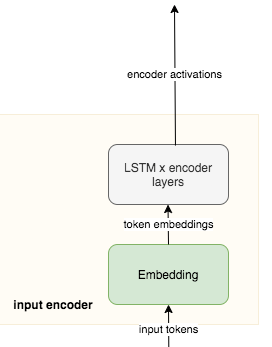</body></html>
<a name="ex01"></a>
### Exercise 01

**Instructions:** Implement the `input_encoder_fn` function.

In [ ]:
# UNQ_C1
def input_encoder_fn(input_vocab_size, d_model, n_encoder_layers):
    """ Input encoder runs on the input sentence and creates
    activations that will be the keys and values for attention.
    
    Args:
        input_vocab_size: int: vocab size of the input
        d_model: int:  depth of embedding (n_units in the LSTM cell)
        n_encoder_layers: int: number of LSTM layers in the encoder
    Returns:
        tl.Serial: The input encoder
    """
    
    # create a serial network
    input_encoder = tl.Serial( 
        
        ### START CODE HERE ###
        # create an embedding layer to convert tokens to vectors
        tl.Embedding(vocab_size=input_vocab_size, d_feature=d_model),
        
        # feed the embeddings to the LSTM layers. It is a stack of n_encoder_layers LSTM layers
        [tl.LSTM(n_units=d_model) for _ in range(n_encoder_layers)]
        ### END CODE HERE ###
    )

    return input_encoder

In [ ]:
# UNIT TEST
# test input_encoder_fn
w1_unittest.test_input_encoder_fn(input_encoder_fn)

 All tests passed


### 2.2.2 Pre-attention decoder

The pre-attention decoder runs on the targets and creates activations that are used as queries in attention. This is a Serial network which is composed of the following:

   - [tl.ShiftRight](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.ShiftRight): This pads a token to the beginning of your target tokens (e.g. `[8, 34, 12]` shifted right is `[0, 8, 34, 12]`). This will act like a start-of-sentence token that will be the first input to the decoder. During training, this shift also allows the target tokens to be passed as input to do teacher forcing.

   - [tl.Embedding](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding): Like in the previous function, this converts each token to its vector representation. In this case, it is the the size of the vocabulary by the dimension of the model: `tl.Embedding(vocab_size, d_model)`. `vocab_size` is the number of entries in the given vocabulary. `d_model` is the number of elements in the word embedding.
   
   - [tl.LSTM](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.LSTM): LSTM layer of size `d_model`.

<img src = "images/pre_attention_decoder.png">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>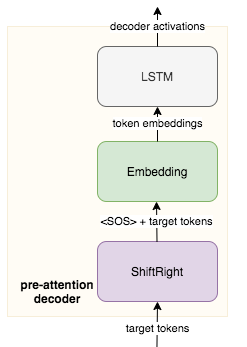</body></html>

<a name="ex02"></a>

### Exercise 02

**Instructions:** Implement the `pre_attention_decoder_fn` function.


In [ ]:
# UNQ_C2
# GRADED FUNCTION
def pre_attention_decoder_fn(mode, target_vocab_size, d_model):
    """ Pre-attention decoder runs on the targets and creates
    activations that are used as queries in attention.
    
    Args:
        mode: str: 'train' or 'eval'
        target_vocab_size: int: vocab size of the target
        d_model: int:  depth of embedding (n_units in the LSTM cell)
    Returns:
        tl.Serial: The pre-attention decoder
    """
    
    # create a serial network
    pre_attention_decoder = tl.Serial(
        
        ### START CODE HERE ###
        # shift right to insert start-of-sentence token and implement
        # teacher forcing during training
        tl.ShiftRight(mode=mode),

        # run an embedding layer to convert tokens to vectors
        tl.Embedding(vocab_size = target_vocab_size, d_feature = d_model),

        # feed to an LSTM layer
        tl.LSTM(n_units= d_model)
        ### END CODE HERE ###
    )
    
    return pre_attention_decoder

In [ ]:
# UNIT TEST
# test pre_attention_decoder_fn
w1_unittest.test_pre_attention_decoder_fn(pre_attention_decoder_fn)

 All tests passed


### 2.2.3 Preparing the attention input

This function will prepare the inputs to the attention layer. We want to take in the encoder and pre-attention decoder activations and assign it to the queries, keys, and values. In addition, another output here will be the mask to distinguish real tokens from padding tokens. This mask will be used internally by Trax when computing the softmax so padding tokens will not have an effect on the computated probabilities. From the data preparation steps in Section 1 of this assignment, you should know which tokens in the input correspond to padding.

We have filled the last two lines in composing the mask for you because it includes a concept that will be discussed further next week. This is related to *multiheaded attention* which you can think of right now as computing the attention multiple times to improve the model's predictions. It is required to consider this additional axis in the output so we've included it already but you don't need to analyze it just yet. What's important now is for you to know which should be the queries, keys, and values, as well as to initialize the mask.

<a name="ex03"></a>
### Exercise 03

**Instructions:** Implement the  `prepare_attention_input` function


In [ ]:
# UNQ_C3
# GRADED FUNCTION
def prepare_attention_input(encoder_activations, decoder_activations, inputs):
    """Prepare queries, keys, values and mask for attention.
    
    Args:
        encoder_activations fastnp.array(batch_size, padded_input_length, d_model): output from the input encoder
        decoder_activations fastnp.array(batch_size, padded_input_length, d_model): output from the pre-attention decoder
        inputs fastnp.array(batch_size, padded_input_length): input tokens
    
    Returns:
        queries, keys, values and mask for attention.
    """
    
    ### START CODE HERE ###
    
    # set the keys and values to the encoder activations
    keys = encoder_activations
    values = encoder_activations

    
    # set the queries to the decoder activations
    queries = decoder_activations
    
    # generate the mask to distinguish real tokens from padding
    # hint: inputs is positive for real tokens and 0 where they are padding
    mask = inputs != 0
    
    ### END CODE HERE ###
    
    # add axes to the mask for attention heads and decoder length.
    mask = fastnp.reshape(mask, (mask.shape[0], 1, 1, mask.shape[1]))
    
    # broadcast so mask shape is [batch size, attention heads, decoder-len, encoder-len].
    # note: for this assignment, attention heads is set to 1.
    mask = mask + fastnp.zeros((1, 1, decoder_activations.shape[1], 1))
        
    
    return queries, keys, values, mask

In [ ]:
# UNIT TEST
# test prepare_attention_input
w1_unittest.test_prepare_attention_input(prepare_attention_input)

 All tests passed


<a name="2.3"></a>
## 2.3  Implementation Overview

We are now ready to implement our sequence-to-sequence model with attention. This will be a Serial network and is illustrated in the diagram below. It shows the layers you'll be using in Trax and you'll see that each step can be implemented quite easily with one line commands. We've placed several links to the documentation for each relevant layer in the discussion after the figure below.

<img src = "images/NMTModel.png">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>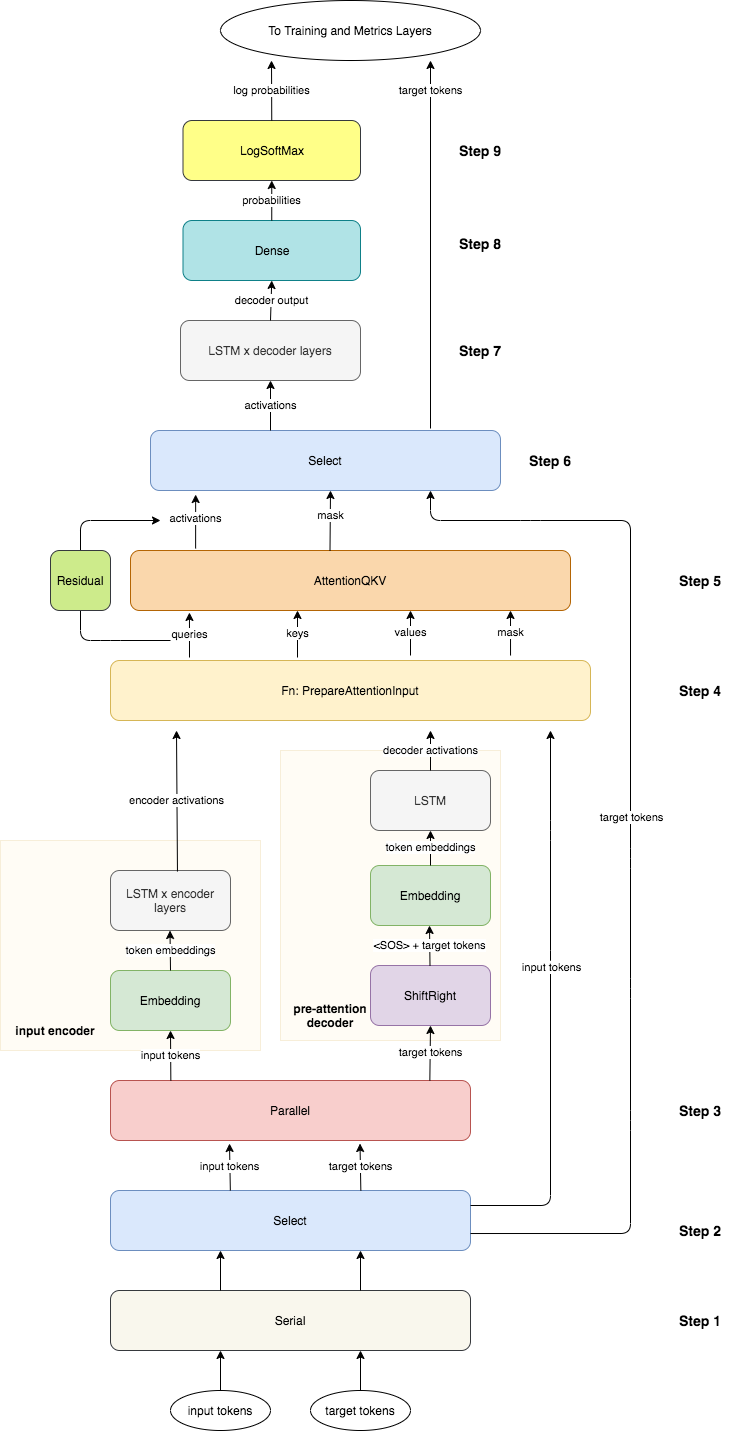</body></html>

<a name="ex04"></a>
### Exercise 04
**Instructions:** Implement the `NMTAttn` function below to define your machine translation model which uses attention. We have left hyperlinks below pointing to the Trax documentation of the relevant layers. Remember to consult it to get tips on what parameters to pass.

**Step 0:** Prepare the input encoder and pre-attention decoder branches. You have already defined this earlier as helper functions so it's just a matter of calling those functions and assigning it to variables.

**Step 1:** Create a Serial network. This will stack the layers in the next steps one after the other. Like the earlier exercises, you can use [tl.Serial](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial).

**Step 2:** Make a copy of the input and target tokens. As you see in the diagram above, the input and target tokens will be fed into different layers of the model. You can use [tl.Select](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Select) layer to create copies of these tokens. Arrange them as `[input tokens, target tokens, input tokens, target tokens]`.

**Step 3:** Create a parallel branch to feed the input tokens to the `input_encoder` and the target tokens to the `pre_attention_decoder`. You can use [tl.Parallel](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Parallel) to create these sublayers in parallel. Remember to pass the variables you defined in Step 0 as parameters to this layer.

**Step 4:** Next, call the `prepare_attention_input` function to convert the encoder and pre-attention decoder activations to a format that the attention layer will accept. You can use [tl.Fn](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn) to call this function. Note: Pass the `prepare_attention_input` function as the `f` parameter in `tl.Fn` without any arguments or parenthesis.

**Step 5:** We will now feed the (queries, keys, values, and mask) to the [tl.AttentionQKV](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.AttentionQKV) layer. This computes the scaled dot product attention and outputs the attention weights and mask. Take note that although it is a one liner, this layer is actually composed of a deep network made up of several branches. We'll show the implementation taken [here](https://github.com/google/trax/blob/master/trax/layers/attention.py#L61) to see the different layers used. 

```python
def AttentionQKV(d_feature, n_heads=1, dropout=0.0, mode='train'):
  """Returns a layer that maps (q, k, v, mask) to (activations, mask).

  See `Attention` above for further context/details.

  Args:
    d_feature: Depth/dimensionality of feature embedding.
    n_heads: Number of attention heads.
    dropout: Probababilistic rate for internal dropout applied to attention
        activations (based on query-key pairs) before dotting them with values.
    mode: Either 'train' or 'eval'.
  """
  return cb.Serial(
      cb.Parallel(
          core.Dense(d_feature),
          core.Dense(d_feature),
          core.Dense(d_feature),
      ),
      PureAttention(  # pylint: disable=no-value-for-parameter
          n_heads=n_heads, dropout=dropout, mode=mode),
      core.Dense(d_feature),
  )
```

Having deep layers pose the risk of vanishing gradients during training and we would want to mitigate that. To improve the ability of the network to learn, we can insert a [tl.Residual](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Residual) layer to add the output of AttentionQKV with the `queries` input. You can do this in trax by simply nesting the `AttentionQKV` layer inside the `Residual` layer. The library will take care of branching and adding for you.

**Step 6:** We will not need the mask for the model we're building so we can safely drop it. At this point in the network, the signal stack currently has `[attention activations, mask, target tokens]` and you can use [tl.Select](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Select) to output just `[attention activations, target tokens]`.

**Step 7:** We can now feed the attention weighted output to the LSTM decoder. We can stack multiple [tl.LSTM](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.LSTM) layers to improve the output so remember to append LSTMs equal to the number defined by `n_decoder_layers` parameter to the model.

**Step 8:** We want to determine the probabilities of each subword in the vocabulary and you can set this up easily with a [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) layer by making its size equal to the size of our vocabulary.

**Step 9:** Normalize the output to log probabilities by passing the activations in Step 8 to a [tl.LogSoftmax](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax) layer.

In [ ]:
# UNQ_C4
# GRADED FUNCTION
def NMTAttn(input_vocab_size=33300,
            target_vocab_size=33300,
            d_model=1024,
            n_encoder_layers=2,
            n_decoder_layers=2,
            n_attention_heads=4,
            attention_dropout=0.0,
            mode='train'):
    """Returns an LSTM sequence-to-sequence model with attention.

    The input to the model is a pair (input tokens, target tokens), e.g.,
    an English sentence (tokenized) and its translation into German (tokenized).

    Args:
    input_vocab_size: int: vocab size of the input
    target_vocab_size: int: vocab size of the target
    d_model: int:  depth of embedding (n_units in the LSTM cell)
    n_encoder_layers: int: number of LSTM layers in the encoder
    n_decoder_layers: int: number of LSTM layers in the decoder after attention
    n_attention_heads: int: number of attention heads
    attention_dropout: float, dropout for the attention layer
    mode: str: 'train', 'eval' or 'predict', predict mode is for fast inference

    Returns:
    An LSTM sequence-to-sequence model with attention.
    """

    ### START CODE HERE ###
    
    # Step 0: call the helper function to create layers for the input encoder
    input_encoder = input_encoder_fn(input_vocab_size, d_model, n_encoder_layers)

    # Step 0: call the helper function to create layers for the pre-attention decoder
    pre_attention_decoder = pre_attention_decoder_fn(mode, target_vocab_size, d_model)

    # Step 1: create a serial network
    model = tl.Serial( 
        
      # Step 2: copy input tokens and target tokens as they will be needed later.
      tl.Select([0,1,0,1]),
        
      # Step 3: run input encoder on the input and pre-attention decoder the target.
      tl.Parallel(input_encoder, pre_attention_decoder),
        
      # Step 4: prepare queries, keys, values and mask for attention.
      tl.Fn('PrepareAttentionInput', prepare_attention_input, n_out=4),
        
      # Step 5: run the AttentionQKV layer
      # nest it inside a Residual layer to add to the pre-attention decoder activations(i.e. queries)
      tl.Residual(tl.AttentionQKV(d_model, n_heads=n_attention_heads, dropout=attention_dropout, mode=mode)),
      
      # Step 6: drop attention mask (i.e. index = None
      tl.Select([0,2]),
        
      # Step 7: run the rest of the RNN decoder
      [tl.LSTM(n_units=d_model) for _ in range(n_decoder_layers)],
        
      # Step 8: prepare output by making it the right size
      tl.Dense(target_vocab_size),
        
      # Step 9: Log-softmax for output
       tl.LogSoftmax()
    )
    
    ### END CODE HERE
    
    return model

In [ ]:
# print your model
model = NMTAttn()
print(model)

Serial_in2_out2[
  Select[0,1,0,1]_in2_out4
  Parallel_in2_out2[
    Serial[
      Embedding_33300_1024
      LSTM_1024
      LSTM_1024
    ]
    Serial[
      Serial[
        ShiftRight(1)
      ]
      Embedding_33300_1024
      LSTM_1024
    ]
  ]
  PrepareAttentionInput_in3_out4
  Serial_in4_out2[
    Branch_in4_out3[
      None
      Serial_in4_out2[
        _in4_out4
        Serial_in4_out2[
          Parallel_in3_out3[
            Dense_1024
            Dense_1024
            Dense_1024
          ]
          PureAttention_in4_out2
          Dense_1024
        ]
        _in2_out2
      ]
    ]
    Add_in2
  ]
  Select[0,2]_in3_out2
  LSTM_1024
  LSTM_1024
  Dense_33300
  LogSoftmax
]


**Expected Output:**

```
Serial_in2_out2[
  Select[0,1,0,1]_in2_out4
  Parallel_in2_out2[
    Serial[
      Embedding_33300_1024
      LSTM_1024
      LSTM_1024
    ]
    Serial[
      Serial[
        ShiftRight(1)
      ]
      Embedding_33300_1024
      LSTM_1024
    ]
  ]
  PrepareAttentionInput_in3_out4
  Serial_in4_out2[
    Branch_in4_out3[
      None
      Serial_in4_out2[
        _in4_out4
        Serial_in4_out2[
          Parallel_in3_out3[
            Dense_1024
            Dense_1024
            Dense_1024
          ]
          PureAttention_in4_out2
          Dense_1024
        ]
        _in2_out2
      ]
    ]
    Add_in2
  ]
  Select[0,2]_in3_out2
  LSTM_1024
  LSTM_1024
  Dense_33300
  LogSoftmax
]
```

In [ ]:
# UNIT TEST
# test_NMTAttn
w1_unittest.test_NMTAttn(NMTAttn)

 All tests passed


<a name="3"></a>
# Part 3:  Training

We will now be training our model in this section. Doing supervised training in Trax is pretty straightforward (short example [here](https://trax-ml.readthedocs.io/en/latest/notebooks/trax_intro.html#Supervised-training)). We will be instantiating three classes for this: `TrainTask`, `EvalTask`, and `Loop`. Let's take a closer look at each of these in the sections below.


<a name="3.1"></a>
## 3.1  TrainTask

The [TrainTask](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.TrainTask) class allows us to define the labeled data to use for training and the feedback mechanisms to compute the loss and update the weights. 

<a name="ex05"></a>
### Exercise 05

**Instructions:** Instantiate a train task.

In [ ]:
# UNQ_C5
# GRADED PART
def train_task_function(train_batch_stream):
    """Returns a trax.training.TrainTask object.

    Args:
    train_batch_stream generator: labeled data generator

    Returns:
    A trax.training.TrainTask object.
    """
    return training.TrainTask(

        ### START CODE HERE

        # use the train batch stream as labeled data
        labeled_data= train_batch_stream,

        # use the cross entropy loss
        loss_layer= tl.CrossEntropyLoss(),

        # use the Adam optimizer with learning rate of 0.01
        optimizer= trax.optimizers.Adam(0.01),

        # use the `trax.lr.warmup_and_rsqrt_decay` as the learning rate schedule
        # have 1000 warmup steps with a max value of 0.01
        lr_schedule= trax.lr.warmup_and_rsqrt_decay(1000, 0.01),

        # have a checkpoint every 10 steps
        n_steps_per_checkpoint= 10,

        ### END CODE HERE
    )

In [ ]:
train_task = train_task_function(train_batch_stream)

In [ ]:
# UNIT TEST
# test_train_task
w1_unittest.test_train_task(train_task_function)

 All tests passed


<a name="3.2"></a>
## 3.2  EvalTask

The [EvalTask](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.EvalTask) on the other hand allows us to see how the model is doing while training. For our application, we want it to report the cross entropy loss and accuracy.

In [ ]:
eval_task = training.EvalTask(
    
    ## use the eval batch stream as labeled data
    labeled_data=eval_batch_stream,
    
    ## use the cross entropy loss and accuracy as metrics
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
)

<a name="3.3"></a>
## 3.3  Loop

The [Loop](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.Loop) class defines the model we will train as well as the train and eval tasks to execute. Its `run()` method allows us to execute the training for a specified number of steps.

In [ ]:
# define the output directory
output_dir = 'output_dir/'

# remove old model if it exists. restarts training.
!rm -f ~/output_dir/model.pkl.gz  

# define the training loop
training_loop = training.Loop(NMTAttn(mode='train'),
                              train_task,
                              eval_tasks=[eval_task],
                              output_dir=output_dir)

In [ ]:
# NOTE: Execute the training loop. This will take around 11 minutes to complete.
training_loop.run(10)


Step     20: Ran 10 train steps in 419.16 secs
Step     20: train CrossEntropyLoss |  9.35603809
Step     20: eval  CrossEntropyLoss |  8.57236576
Step     20: eval          Accuracy |  0.04535790


<a name="4"></a>
# Part 4:  Testing

We will now be using the model you just trained to translate English sentences to German. We will implement this with two functions: The first allows you to identify the next symbol (i.e. output token). The second one takes care of combining the entire translated string.

We will start by first loading in a pre-trained copy of the model you just coded. Please run the cell below to do just that.

In [ ]:
# instantiate the model we built in eval mode
model = NMTAttn(mode='eval')

# initialize weights from a pre-trained model
model.init_from_file("model.pkl.gz", weights_only=True)
model = tl.Accelerate(model)

<a name="4.1"></a>
## 4.1  Decoding

As discussed in the lectures, there are several ways to get the next token when translating a sentence. For instance, we can just get the most probable token at each step (i.e. greedy decoding) or get a sample from a distribution. We can generalize the implementation of these two approaches by using the `tl.logsoftmax_sample()` method. Let's briefly look at its implementation:

```python
def logsoftmax_sample(log_probs, temperature=1.0):  # pylint: disable=invalid-name
  """Returns a sample from a log-softmax output, with temperature.

  Args:
    log_probs: Logarithms of probabilities (often coming from LogSofmax)
    temperature: For scaling before sampling (1.0 = default, 0.0 = pick argmax)
  """
  # This is equivalent to sampling from a softmax with temperature.
  u = np.random.uniform(low=1e-6, high=1.0 - 1e-6, size=log_probs.shape)
  g = -np.log(-np.log(u))
  return np.argmax(log_probs + g * temperature, axis=-1)
```

The key things to take away here are: 1. it gets random samples with the same shape as your input (i.e. `log_probs`), and 2. the amount of "noise" added to the input by these random samples is scaled by a `temperature` setting. You'll notice that setting it to `0` will just make the return statement equal to getting the argmax of `log_probs`. This will come in handy later. 

<a name="ex06"></a>
### Exercise 06

**Instructions:** Implement the `next_symbol()` function that takes in the `input_tokens` and the `cur_output_tokens`, then return the index of the next word. You can click below for hints in completing this exercise.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Click Here for Hints</b></font>
</summary>
<p>
<ul>
    <li>To get the next power of two, you can compute <i>2^log_2(token_length + 1)</i> . We add 1 to avoid <i>log(0).</i></li>
    <li>You can use <i>np.ceil()</i> to get the ceiling of a float.</li>
    <li><i>np.log2()</i> will get the logarithm base 2 of a value</li>
    <li><i>int()</i> will cast a value into an integer type</li>
    <li>From the model diagram in part 2, you know that it takes two inputs. You can feed these with this syntax to get the model outputs: <i>model((input1, input2))</i>. It's up to you to determine which variables below to substitute for input1 and input2. Remember also from the diagram that the output has two elements: [log probabilities, target tokens]. You won't need the target tokens so we assigned it to _ below for you. </li>
    <li> The log probabilities output will have the shape: (batch size, decoder length, vocab size). It will contain log probabilities for each token in the <i>cur_output_tokens</i> plus 1 for the start symbol introduced by the ShiftRight in the preattention decoder. For example, if cur_output_tokens is [1, 2, 5], the model will output an array of log probabilities each for tokens 0 (start symbol), 1, 2, and 5. To generate the next symbol, you just want to get the log probabilities associated with the last token (i.e. token 5 at index 3). You can slice the model output at [0, 3, :] to get this. It will be up to you to generalize this for any length of cur_output_tokens </li>
</ul>


In [ ]:
# UNQ_C6
# GRADED FUNCTION
def next_symbol(NMTAttn, input_tokens, cur_output_tokens, temperature):
    """Returns the index of the next token.

    Args:
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        input_tokens (np.ndarray 1 x n_tokens): tokenized representation of the input sentence
        cur_output_tokens (list): tokenized representation of previously translated words
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)

    Returns:
        int: index of the next token in the translated sentence
        float: log probability of the next symbol
    """

    ### START CODE HERE ###

    # set the length of the current output tokens
    token_length = len(cur_output_tokens)
    
    # calculate next power of 2 for padding length 
    padded_length =  np.power(2, int(np.ceil(np.log2(token_length + 1))))

    # pad cur_output_tokens up to the padded_length
    padded = cur_output_tokens + [0] * (padded_length - token_length)
    
    # model expects the output to have an axis for the batch size in front so
    # convert `padded` list to a numpy array with shape (1, <padded_length>)
    padded_with_batch = np.expand_dims(padded, axis=0)

    # get the model prediction
    output, _ = NMTAttn((input_tokens, padded_with_batch))
    
    # get log probabilities from the last token output
    log_probs = output[0, token_length, :]

    # get the next symbol by getting a logsoftmax sample (*hint: cast to an int)
    symbol = int(tl.logsoftmax_sample(log_probs, temperature))
    
    ### END CODE HERE ###    
    return symbol, float(log_probs[symbol])

In [ ]:
# UNIT TEST
# test_next_symbol
w1_unittest.test_next_symbol(next_symbol, NMTAttn)

 All tests passed


Now you will implement the `sampling_decode()` function. This will call the `next_symbol()` function above several times until the next output is the end-of-sentence token (i.e. `EOS`). It takes in an input string and returns the translated version of that string.

<a name="ex07"></a>
### Exercise 07

**Instructions**: Implement the `sampling_decode()` function.

In [ ]:
# UNQ_C7
# GRADED FUNCTION
def sampling_decode(input_sentence, NMTAttn = None, temperature=0.0, vocab_file=None, vocab_dir=None, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Returns the translated sentence.

    Args:
        input_sentence (str): sentence to translate.
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        tuple: (list, str, float)
            list of int: tokenized version of the translated sentence
            float: log probability of the translated sentence
            str: the translated sentence
    """
    
    ### START CODE HERE ###
    
    # encode the input sentence
    input_tokens = tokenize(input_sentence,vocab_file,vocab_dir)
    
    # initialize an empty the list of output tokens
    cur_output_tokens = []
    
    # initialize an integer that represents the current output index
    cur_output = 0
    
    # Set the encoding of the "end of sentence" as 1
    EOS = 1
    
    # check that the current output is not the end of sentence token
    while cur_output != EOS:
        
        # update the current output token by getting the index of the next word (hint: use next_symbol)
        cur_output, log_prob = next_symbol(NMTAttn, input_tokens, cur_output_tokens, temperature)
        
        # append the current output token to the list of output tokens
        cur_output_tokens.append(cur_output)        
    
    # detokenize the output tokens
    sentence = detokenize(cur_output_tokens, vocab_file, vocab_dir)
    
    ### END CODE HERE ###
    
    return cur_output_tokens, log_prob, sentence

In [ ]:
# Test the function above. Try varying the temperature setting with values from 0 to 1.
# Run it several times with each setting and see how often the output changes. 
sampling_decode("I love languages.", NMTAttn=model, temperature=0.0, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)

([161, 12202, 5112, 3, 1], -0.0001735687255859375, 'Ich liebe Sprachen.')

In [ ]:
# UNIT TEST
# test sampling_decode
w1_unittest.test_sampling_decode(sampling_decode)

 All tests passed


We have set a default value of `0` to the temperature setting in our implementation of `sampling_decode()` above. As you may have noticed in the `logsoftmax_sample()` method, this setting will ultimately result in greedy decoding. As mentioned in the lectures, this algorithm generates the translation by getting the most probable word at each step. It gets the argmax of the output array of your model and then returns that index. See the testing function and sample inputs below. You'll notice that the output will remain the same each time you run it.

In [ ]:
def greedy_decode_test(sentence, NMTAttn=None, vocab_file=None, vocab_dir=None, sampling_decode=sampling_decode, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Prints the input and output of our NMTAttn model using greedy decode

    Args:
        sentence (str): a custom string.
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        str: the translated sentence
    """
    
    _,_, translated_sentence = sampling_decode(sentence, NMTAttn=NMTAttn, vocab_file=vocab_file, vocab_dir=vocab_dir, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize)
    
    print("English: ", sentence)
    print("German: ", translated_sentence)
    
    return translated_sentence

In [ ]:
# put a custom string here
your_sentence = 'I am hungry'

greedy_decode_test(your_sentence, NMTAttn=model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR);

English:  I am hungry
German:  Ich bin hungrig.


In [ ]:
greedy_decode_test('You are almost done with the assignment!', model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR);

English:  You are almost done with the assignment!
German:  Sie sind fast mit der Aufgabe fertig!


<a name="4.2"></a>
## 4.2  Minimum Bayes-Risk Decoding

As mentioned in the lectures, getting the most probable token at each step may not necessarily produce the best results. Another approach is to do Minimum Bayes Risk Decoding or MBR. The general steps to implement this are:

1. take several random samples
2. score each sample against all other samples
3. select the one with the highest score

You will be building helper functions for these steps in the following sections.

<a name='4.2.1'></a>
### 4.2.1 Generating samples

First, let's build a function to generate several samples. You can use the `sampling_decode()` function you developed earlier to do this easily. We want to record the token list and log probability for each sample as these will be needed in the next step.

In [ ]:
def generate_samples(sentence, n_samples, NMTAttn=None, temperature=0.6, vocab_file=None, vocab_dir=None, sampling_decode=sampling_decode, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Generates samples using sampling_decode()

    Args:
        sentence (str): sentence to translate.
        n_samples (int): number of samples to generate
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file
        
    Returns:
        tuple: (list, list)
            list of lists: token list per sample
            list of floats: log probability per sample
    """
    # define lists to contain samples and probabilities
    samples, log_probs = [], []

    # run a for loop to generate n samples
    for _ in range(n_samples):
        
        # get a sample using the sampling_decode() function
        sample, logp, _ = sampling_decode(sentence, NMTAttn, temperature, vocab_file=vocab_file, vocab_dir=vocab_dir, next_symbol=next_symbol)
        
        # append the token list to the samples list
        samples.append(sample)
        
        # append the log probability to the log_probs list
        log_probs.append(logp)
                
    return samples, log_probs

In [ ]:
# generate 4 samples with the default temperature (0.6)
generate_samples('how are you today?', 4, model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)

([[595, 75, 67, 352, 102, 1],
  [595, 75, 67, 352, 102, 1],
  [93, 75, 67, 352, 102, 1],
  [93, 2743, 156, 352, 102, 1]],
 [-3.814697265625e-06,
  -3.814697265625e-06,
  -1.9073486328125e-06,
  -5.7220458984375e-06])

### 4.2.2 Comparing overlaps

Let us now build our functions to compare a sample against another. There are several metrics available as shown in the lectures and you can try experimenting with any one of these. For this assignment, we will be calculating scores for unigram overlaps. One of the more simple metrics is the [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) which gets the intersection over union of two sets. We've already implemented it below for your perusal.

In [ ]:
def jaccard_similarity(candidate, reference):
    """Returns the Jaccard similarity between two token lists

    Args:
        candidate (list of int): tokenized version of the candidate translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """
    
    # convert the lists to a set to get the unique tokens
    can_unigram_set, ref_unigram_set = set(candidate), set(reference)  
    
    # get the set of tokens common to both candidate and reference
    joint_elems = can_unigram_set.intersection(ref_unigram_set)
    
    # get the set of all tokens found in either candidate or reference
    all_elems = can_unigram_set.union(ref_unigram_set)
    
    # divide the number of joint elements by the number of all elements
    overlap = len(joint_elems) / len(all_elems)
    
    return overlap

In [ ]:
# let's try using the function. remember the result here and compare with the next function below.
jaccard_similarity([1, 2, 3], [1, 2, 3, 4])

0.75

One of the more commonly used metrics in machine translation is the ROUGE score. For unigrams, this is called ROUGE-1 and as shown in class, you can output the scores for both precision and recall when comparing two samples. To get the final score, you will want to compute the F1-score as given by:

$$score = 2* \frac{(precision * recall)}{(precision + recall)}$$

<a name="ex08"></a>
### Exercise 08

**Instructions**: Implement the `rouge1_similarity()` function.

In [ ]:
# UNQ_C8
# GRADED FUNCTION

# for making a frequency table easily
from collections import Counter

def rouge1_similarity(system, reference):
    """Returns the ROUGE-1 score between two token lists

    Args:
        system (list of int): tokenized version of the system translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """    
    
    ### START CODE HERE
    
    # make a frequency table of the system tokens (hint: use the Counter class)
    sys_counter = Counter(system)
    
    # make a frequency table of the reference tokens (hint: use the Counter class)
    ref_counter = Counter(reference)
    
    # initialize overlap to 0
    overlap = 0
    
    # run a for loop over the sys_counter object (can be treated as a dictionary)
    for token in sys_counter:
        
        # lookup the value of the token in the sys_counter dictionary (hint: use the get() method)
        token_count_sys = sys_counter.get(token,0)
        
        # lookup the value of the token in the ref_counter dictionary (hint: use the get() method)
        token_count_ref = ref_counter.get(token,0)
        
        # update the overlap by getting the smaller number between the two token counts above
        overlap += min(token_count_sys, token_count_ref)
    
    # get the precision
    precision = overlap / sum(sys_counter.values())
    
    # get the recall
    recall = overlap / sum(ref_counter.values())
    
    if precision + recall != 0: # @KEEPTHIS
        # compute the f1-score
        rouge1_score = 2 * ((precision * recall)/(precision + recall))
    else:
        rouge1_score = 0 
    ### END CODE HERE
    
    return rouge1_score

In [ ]:
# notice that this produces a different value from the jaccard similarity earlier
rouge1_similarity([1, 2, 3], [1, 2, 3, 4])

0.8571428571428571

In [ ]:
# UNIT TEST
# test rouge1_similarity
w1_unittest.test_rouge1_similarity(rouge1_similarity)

 All tests passed


### 4.2.3 Overall score

We will now build a function to generate the overall score for a particular sample. As mentioned earlier, we need to compare each sample with all other samples. For instance, if we generated 30 sentences, we will need to compare sentence 1 to sentences 2 to 30. Then, we compare sentence 2 to sentences 1 and 3 to 30, and so forth. At each step, we get the average score of all comparisons to get the overall score for a particular sample. To illustrate, these will be the steps to generate the scores of a 4-sample list.

1. Get similarity score between sample 1 and sample 2
2. Get similarity score between sample 1 and sample 3
3. Get similarity score between sample 1 and sample 4
4. Get average score of the first 3 steps. This will be the overall score of sample 1.
5. Iterate and repeat until samples 1 to 4 have overall scores.

We will be storing the results in a dictionary for easy lookups.

<a name="ex09"></a>
### Exercise 09

**Instructions**: Implement the `average_overlap()` function.

In [ ]:
# UNQ_C9
# GRADED FUNCTION
def average_overlap(similarity_fn, samples, *ignore_params):
    """Returns the arithmetic mean of each candidate sentence in the samples

    Args:
        similarity_fn (function): similarity function used to compute the overlap
        samples (list of lists): tokenized version of the translated sentences
        *ignore_params: additional parameters will be ignored

    Returns:
        dict: scores of each sample
            key: index of the sample
            value: score of the sample
    """  
    
    # initialize dictionary
    scores = {}
    
    # run a for loop for each sample
    for index_candidate, candidate in enumerate(samples):    
        
        ### START CODE HERE
        
        # initialize overlap
        overlap = 0.0
        
        # run a for loop for each sample
        for index_sample, sample in enumerate(samples): # @KEEPTHIS

            # skip if the candidate index is the same as the sample index
            if index_candidate == index_sample:
                continue
                
            # get the overlap between candidate and sample using the similarity function
            sample_overlap = similarity_fn(candidate,sample)
            
            # add the sample overlap to the total overlap
            overlap += sample_overlap
            
        # get the score for the candidate by computing the average
        score = overlap/index_sample
        
        # save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
        
        ### END CODE HERE
    return scores

In [ ]:
average_overlap(jaccard_similarity, [[1, 2, 3], [1, 2, 4], [1, 2, 4, 5]], [0.4, 0.2, 0.5])

{0: 0.45, 1: 0.625, 2: 0.575}

In [ ]:
# UNIT TEST
# test average_overlap
w1_unittest.test_average_overlap(average_overlap, rouge1_similarity)

 All tests passed


In practice, it is also common to see the weighted mean being used to calculate the overall score instead of just the arithmetic mean. We have implemented it below and you can use it in your experiements to see which one will give better results.

In [ ]:
def weighted_avg_overlap(similarity_fn, samples, log_probs):
    """Returns the weighted mean of each candidate sentence in the samples

    Args:
        samples (list of lists): tokenized version of the translated sentences
        log_probs (list of float): log probability of the translated sentences

    Returns:
        dict: scores of each sample
            key: index of the sample
            value: score of the sample
    """
    
    # initialize dictionary
    scores = {}
    
    # run a for loop for each sample
    for index_candidate, candidate in enumerate(samples):    
        
        # initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0
        
        # run a for loop for each sample
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # skip if the candidate index is the same as the sample index            
            if index_candidate == index_sample:
                continue
                
            # convert log probability to linear scale
            sample_p = float(np.exp(logp))

            # update the weighted sum
            weight_sum += sample_p

            # get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)
            
            # update the overlap
            overlap += sample_p * sample_overlap
            
        # get the score for the candidate
        score = overlap / weight_sum
        
        # save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
    
    return scores

In [ ]:
weighted_avg_overlap(jaccard_similarity, [[1, 2, 3], [1, 2, 4], [1, 2, 4, 5]], [0.4, 0.2, 0.5])

{0: 0.44255574831883415, 1: 0.631244796869735, 2: 0.5575581009406329}

### 4.2.4 Putting it all together

We will now put everything together and develop the `mbr_decode()` function. Please use the helper functions you just developed to complete this. You will want to generate samples, get the score for each sample, get the highest score among all samples, then detokenize this sample to get the translated sentence.

<a name="ex10"></a>
### Exercise 10

**Instructions**: Implement the `mbr_decode()` function.

In [1]:
# UNQ_C10
# GRADED FUNCTION
def mbr_decode(sentence, n_samples, score_fn, similarity_fn, NMTAttn=None, temperature=0.6, vocab_file=None, vocab_dir=None, generate_samples=generate_samples, sampling_decode=sampling_decode, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Returns the translated sentence using Minimum Bayes Risk decoding

    Args:
        sentence (str): sentence to translate.
        n_samples (int): number of samples to generate
        score_fn (function): function that generates the score for each sample
        similarity_fn (function): function used to compute the overlap between a pair of samples
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        str: the translated sentence
    """
    
    ### START CODE HERE ###
    # generate samples
    samples, log_probs = generate_samples(sentence, n_samples, NMTAttn, temperature, vocab_file, vocab_dir)
    
    # use the scoring function to get a dictionary of scores
    # pass in the relevant parameters as shown in the function definition of 
    # the mean methods you developed earlier
    scores = weighted_avg_overlap(jaccard_similarity, samples, log_probs)
    
    # find the key with the highest score
    max_score_key = max(scores, key=scores.get)
    
    # detokenize the token list associated with the max_score_key
    translated_sentence = detokenize(samples[max_score_key], vocab_file, vocab_dir)
    
    ### END CODE HERE ###
    
    return (translated_sentence, max_score_key, scores)

NameError: ignored

In [ ]:
TEMPERATURE = 1.0

# put a custom string here
your_sentence = 'She speaks English and German.'

In [ ]:
mbr_decode(your_sentence, 4, weighted_avg_overlap, jaccard_similarity, model, TEMPERATURE, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)[0]

In [ ]:
mbr_decode('Congratulations!', 4, average_overlap, rouge1_similarity, model, TEMPERATURE, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)[0]

In [ ]:
mbr_decode('You have completed the assignment!', 4, average_overlap, rouge1_similarity, model, TEMPERATURE, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)[0]

In [ ]:
# UNIT TEST
# test mbr_decode
w1_unittest.test_mbr_decode(target=mbr_decode, score_fn=average_overlap, similarity_fn=rouge1_similarity)

#### Congratulations! Next week, you'll dive deeper into attention models and study the Transformer architecture. You will build another network but without the recurrent part. It will show that attention is all you need! It should be fun!